## Классификации эмоций в аудио

На основе датасета аудио RAVDESS и модели Wav2Vec2.0 нужно научиться предсказывать эмоции на тестовой выборке

**Подготовка датасета**

Датасет RAVDESS состоит из аудио, озвученных 24 разными актёрами, в равной пропорции женщинами и мужчинами. Каждый актёр озвучил каждую фразу каждой эмоцией по два раза, правда разных фраз всего было две - "Kids are talking by the door" и "Dogs are sitting by the door". Помимо прочего, в датасете есть сила эмоции normal и strong, но для neutral эмоции strong нет.

По большому счёту нам интересна только сама эмоция, так как ничего остального предсказывать нас не просят, и никаких дополнительных фичей в тренировочном датасете нет.

In [1]:
!pip install numpy
!pip install librosa
!pip install ffmpeg
!pip install torch
!pip install transformers
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import librosa
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from tqdm import tqdm

In [4]:
Ravdess = "data/Ravdess/"
ravdess_directory_list = os.listdir(Ravdess)

files_emotion = []
files_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part represents the emotion
        files_emotion.append(int(part[2]))
        files_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(files_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(files_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,data/Ravdess/Actor_21/03-01-05-02-02-02-21.wav
1,calm,data/Ravdess/Actor_21/03-01-02-01-01-02-21.wav
2,surprise,data/Ravdess/Actor_21/03-01-08-02-01-01-21.wav
3,sad,data/Ravdess/Actor_21/03-01-04-02-02-02-21.wav
4,surprise,data/Ravdess/Actor_21/03-01-08-02-02-01-21.wav


<Axes: xlabel='Emotions', ylabel='Count'>

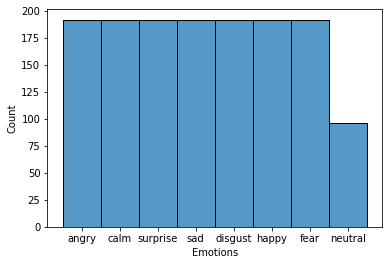

In [5]:
sns.histplot(data=Ravdess_df, x="Emotions")

Классы не сбалансированны из-за того, что для neutral только одна интенсивность и, соответсвенно, в два раза меньше записей

## Wav2Vec2

Теперь извлечём фичи из наших аудио с помощью эмбеддингов предобученной Wav2Vec2. Для этого мы прогоним наши аудио через модель и получим состояние последнего скрытого слоя. Уже на этих значениях, как фичах, будем тренировать собственный классификатор

In [6]:
# Initialising

# we use the facebook pretrained model
model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Будем использовать частоту дискретизации 16k, так как на этом значении обучалась Wav2Vec2. Помимо этого, в документации указано, что нормализация входящего аудио может существенно улучшить результаты, так что сделаем это

In [101]:
def get_feature(input_audio):
    
    # normilising the input, so that it has zero mean and unit variance
    normalised_input = feature_extractor(input_audio, return_tensors="pt", 
                                         feature_size=1, sampling_rate=sample_rate,
                                        padding=True)

    with torch.no_grad():
        # getting the representation in Wav2Vec2
        outputs = model(normalised_input.input_values, output_hidden_states=True)

    embeddings = outputs.last_hidden_state

    return np.mean(embeddings[0].numpy(), axis=0).astype(np.float32)

In [120]:
features = []

for file_path in tqdm(Ravdess_df.Path):
    input_audio, sample_rate = librosa.load(file_path,  sr=16000)
    features.append(get_feature(input_audio))

features = np.array(features)

100%|███████████████████████████████████████| 1440/1440 [16:15<00:00,  1.48it/s]


In [121]:
features.shape

(1440, 1024)

In [15]:
with open('Github/data/features', 'wb') as f:
    np.save(f, features)

In [16]:
with open('Github/data/train_labels', 'wb') as f:
    np.save(f, np.array(files_emotion))

## Классификация

Было рассмотрено несколько классификаторов в файле comparing_models.ipynb . Лучший скор был у градиентного бустинга с n_estimators = 1000 и max_depth = 5. Здесь мы им и воспользуемся. 

С более подробным сравнением моделей можно ознакомится в comparing_models.ipynb 

In [13]:
X = pd.DataFrame(features)
y = pd.Series(Ravdess_df.Emotions)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

clf = GradientBoostingClassifier(warm_start=True, max_depth=2, 
                                 learning_rate=0.1, subsample=1,
                                n_estimators=100)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

clf.fit(X_train, y_train)
print("Train: ", clf.score(X_train, y_train))
print("Test: ", clf.score(X_test, y_test))

Train:  0.9927385892116183
Test:  0.48739495798319327


Итоговый скор - 48.7%, что весьма неплохо. Сохраним веса модели

In [18]:
import pickle
# save the model to disk
filename = 'GradientBoostingClassifier_weights.sav'
pickle.dump(clf, open(filename, 'wb'))

Рассмотрим больше метрик по каждому классу

In [20]:
from sklearn.metrics import classification_report

print('Results on the test set:')
print(classification_report(y_test, clf.predict(X_test)))

Results on the test set:
              precision    recall  f1-score   support

       angry       0.64      0.65      0.65        63
        calm       0.53      0.60      0.56        63
     disgust       0.45      0.52      0.49        63
        fear       0.62      0.59      0.61        64
       happy       0.37      0.44      0.40        64
     neutral       0.42      0.25      0.31        32
         sad       0.25      0.21      0.23        63
    surprise       0.54      0.52      0.53        64

    accuracy                           0.49       476
   macro avg       0.48      0.47      0.47       476
weighted avg       0.48      0.49      0.48       476



Видно, что с эмоциями злости, страха, удивления модель справляется лучше всего. И хуже всего с грустью